# Benchmarks

In [1]:
import pandas as pd

results = pd.read_csv('results.csv')

# We also get the library name without the chevrons, like HyperLogLog<6, 7> -> HyperLogLog
results['library'] = results['struct_name'].str.split('<').str[0]

# We specify the HyperLogLog library as value HyperLogLog{BITS}, where BITS is the second
# number in the chevrons, like HyperLogLog<6, 7> -> HyperLogLog{7}

results['library'] = [
    library if not struct_name.startswith('HyperLogLog<') else f'HyperLogLog{struct_name.split(",")[1].split(">")[0].strip()}'
    for library, struct_name in zip(
        results['library'],
        results['struct_name']
    )
]

results = results.dropna()

# We merge the performance associated to left and right cardinalities and average them out.

for left_column in list(results.columns):
    if "left" not in left_column:
        continue
    right_column = left_column.replace("left", "right")
    new_column_name = left_column.replace("left_", "")
    results[new_column_name] = (results[left_column] + results[right_column]) / 2

    results = results.drop([left_column, right_column], axis=1)

# We separate in a column the precision exponent of the struct name, like HyperLogLog<6, 4> -> 6 or TabacHyperLogLogPlus<12> -> 12

results['precision'] = results['struct_name'].str.split('<').str[1].str.split(',').str[0].str.split('>').str[0].astype(float)

results

,struct_name,memory_requirements,population_time,cardinality_time,intersection_cardinality_time,union_cardinality_time,intersection_cardinality,union_cardinality,exact_intersection_cardinality,exact_union_cardinality,intersection_cardinality_squared_error,union_cardinality_squared_error,library,cardinality,exact_cardinality,cardinality_squared_error,precision
0,"HyperLogLog<4, 4>",24,1575029,4723,1433,2762,79514.0,79514,95193,95193,245831041,245831041,HyperLogLog4,79514.0,95193.0,245831041.0,4.0
1,"HyperLogLog<4, 5>",32,1899764,3470,1814,1855,81967.0,81967,95193,95193,174927076,174927076,HyperLogLog5,81967.0,95193.0,174927076.0,4.0
2,"HyperLogLog<4, 6>",40,1923746,206,6447,1513,81967.0,81967,95193,95193,174927076,174927076,HyperLogLog6,81967.0,95193.0,174927076.0,4.0
3,"HyperLogLog<5, 4>",40,1721626,275,2254,2063,88588.0,88588,95193,95193,43626025,43626025,HyperLogLog4,88588.0,95193.0,43626025.0,5.0
4,"HyperLogLog<5, 5>",56,1988010,194,2123,209,89628.0,89628,95193,95193,30969225,30969225,HyperLogLog5,89628.0,95193.0,30969225.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789995,TabacHyperLogLogPlus<12>,20540,224262294,12752,26568,17723,1004162.0,1004162,999958,999958,17673616,17673616,TabacHyperLogLogPlus,1004162.0,999958.0,17673616.0,12.0
789996,TabacHyperLogLogPlus<13>,40556,224458351,21660,51678,34860,1007898.0,1007898,999958,999958,63043600,63043600,TabacHyperLogLogPlus,1007898.0,999958.0,63043600.0,13.0
789997,TabacHyperLogLogPlus<14>,80880,228632459,36927,104382,70793,1003716.0,1003716,999958,999958,14122564,14122564,TabacHyperLogLogPlus,1003716.0,999958.0,14122564.0,14.0
789998,TabacHyperLogLogPlus<15>,161372,237546268,70835,207511,141074,1007787.0,1007787,999958,999958,61293241,61293241,TabacHyperLogLogPlus,1007787.0,999958.0,61293241.0,15.0


In [2]:
from tqdm.auto import tqdm
import numpy as np

tasks = [
    column.replace("_squared_error", "")
    for column in results.columns
    if "squared_error" in column
]

rates = []

for task in tqdm(tasks, desc="Computing rates", leave=False):
    for precision in tqdm(results.precision.unique(), desc=f"Precision", leave=False):
        if pd.isna(precision):
            continue
        reference = results[
            (results.precision == precision) &
            (results.library == "HyperLogLog6")
        ]
        if reference.empty:
            raise ValueError(f"No reference for precision {precision}")
        for library in results.library.unique():
            if library == "HashSet":
                continue
            this_struct = results[
                (results.precision == precision) &
                (results.library == library)
            ]
            for column in [f"{task}_squared_error", f"{task}_time"]:
                rate = this_struct[column].mean() / reference[column].mean()
                assert np.isfinite(rate), (
                    f"Rate is not finite for task {task}, precision {precision}, "
                    f"library {library}, column {column}. The reference value is "
                    f"{reference[column].mean()}. The value is {this_struct[column].mean()}."
                )
                rates.append({
                    "task": task,
                    "precision": precision,
                    "library": library,
                    "column": column,
                    "rate": rate
                })

rates = pd.DataFrame(rates)
rates

Computing rates:   0%|          | 0/3 [00:00<?, ?it/s]

Precision:   0%|          | 0/14 [00:00<?, ?it/s]

Precision:   0%|          | 0/14 [00:00<?, ?it/s]

Precision:   0%|          | 0/14 [00:00<?, ?it/s]

,task,precision,library,column,rate
0,intersection_cardinality,4.0,HyperLogLog4,intersection_cardinality_squared_error,50.764503
1,intersection_cardinality,4.0,HyperLogLog4,intersection_cardinality_time,0.860228
2,intersection_cardinality,4.0,HyperLogLog5,intersection_cardinality_squared_error,1.000000
3,intersection_cardinality,4.0,HyperLogLog5,intersection_cardinality_time,0.873061
4,intersection_cardinality,4.0,HyperLogLog6,intersection_cardinality_squared_error,1.000000
...,...,...,...,...,...
463,cardinality,16.0,SAHyperLogLog,cardinality_time,0.007759
464,cardinality,16.0,TabacHyperLogLogPF,cardinality_squared_error,7.957649
465,cardinality,16.0,TabacHyperLogLogPF,cardinality_time,6.096898
466,cardinality,16.0,TabacHyperLogLogPlus,cardinality_squared_error,7.719952


Plotting:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_3717/1067107340.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2["precision_float"] = df2.reset_index()[("precision",)].astype(float).astype(int).values
/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_3717/1067107340.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2["library_name"] = df2.reset_index()[("library",)].str.len()
/Users/lucacappelletti/opt/miniconda3/envs/py38/lib/python3.8/site-packages/barplots/barplot.py:375: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(min_length, max_length)
/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_3717/1067107340.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2["precision_float"] = df2.reset_index()[("precision",)].astype(float).astype(int).values
/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_3717/

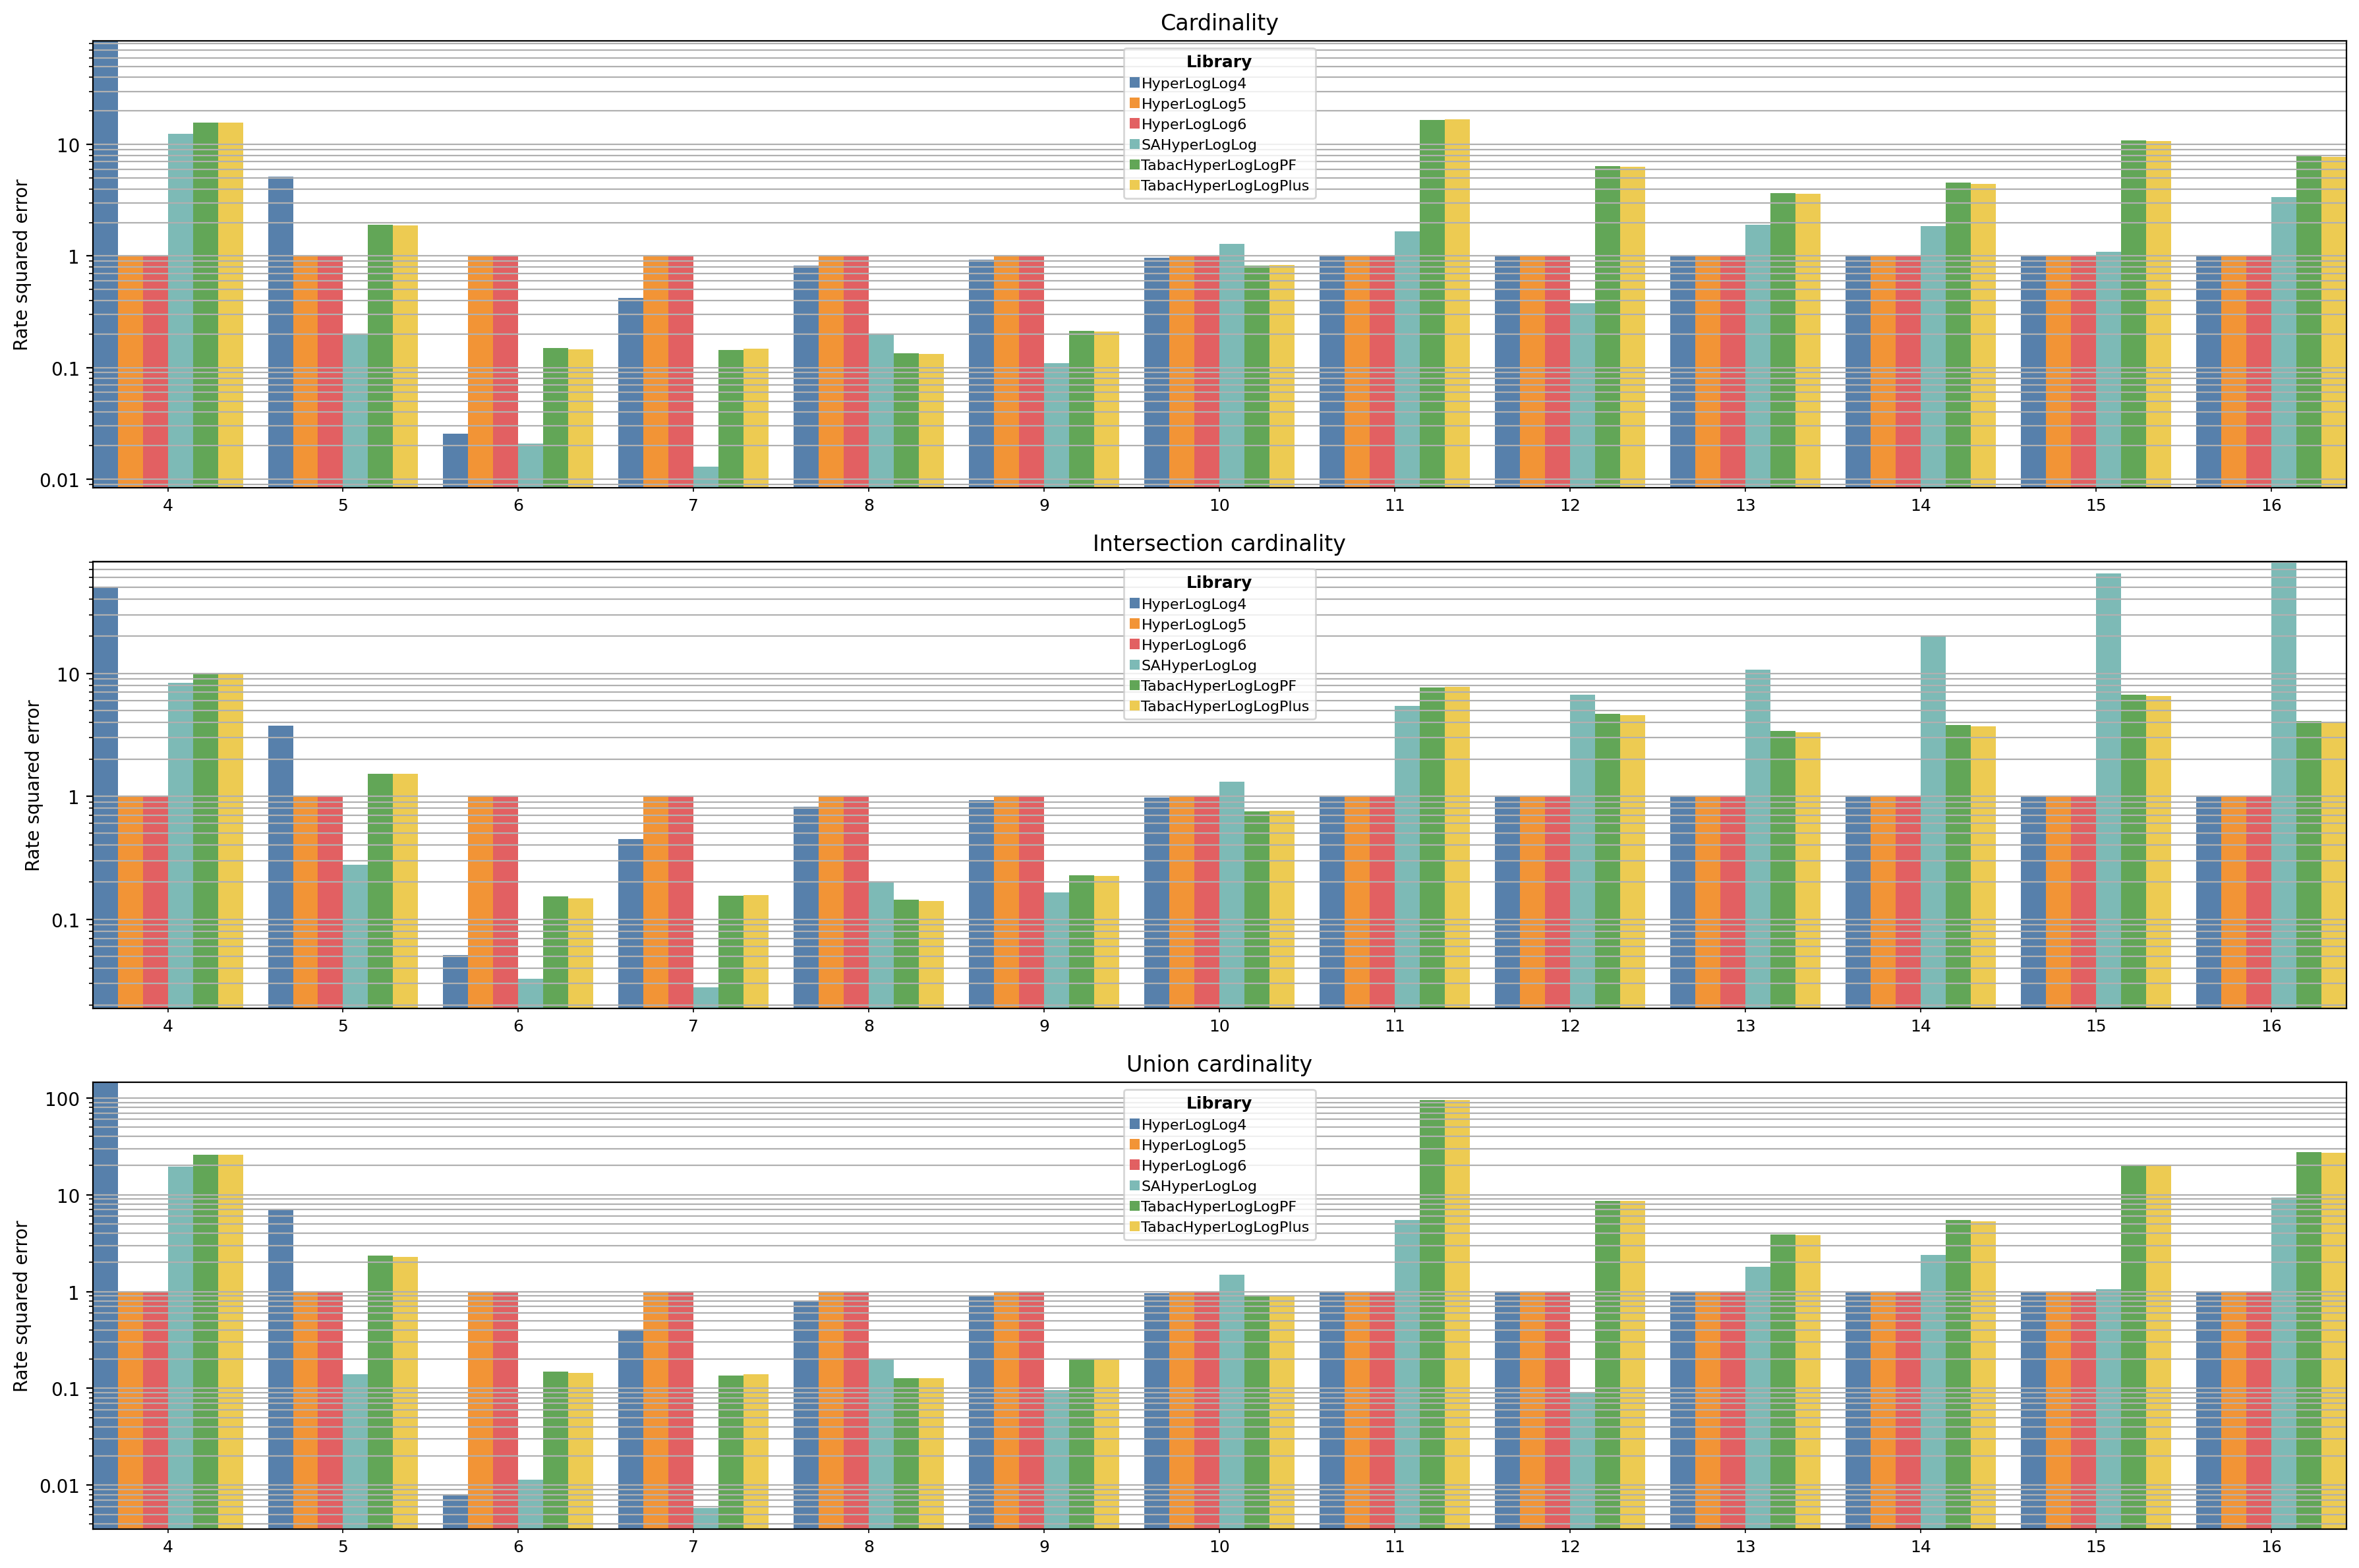

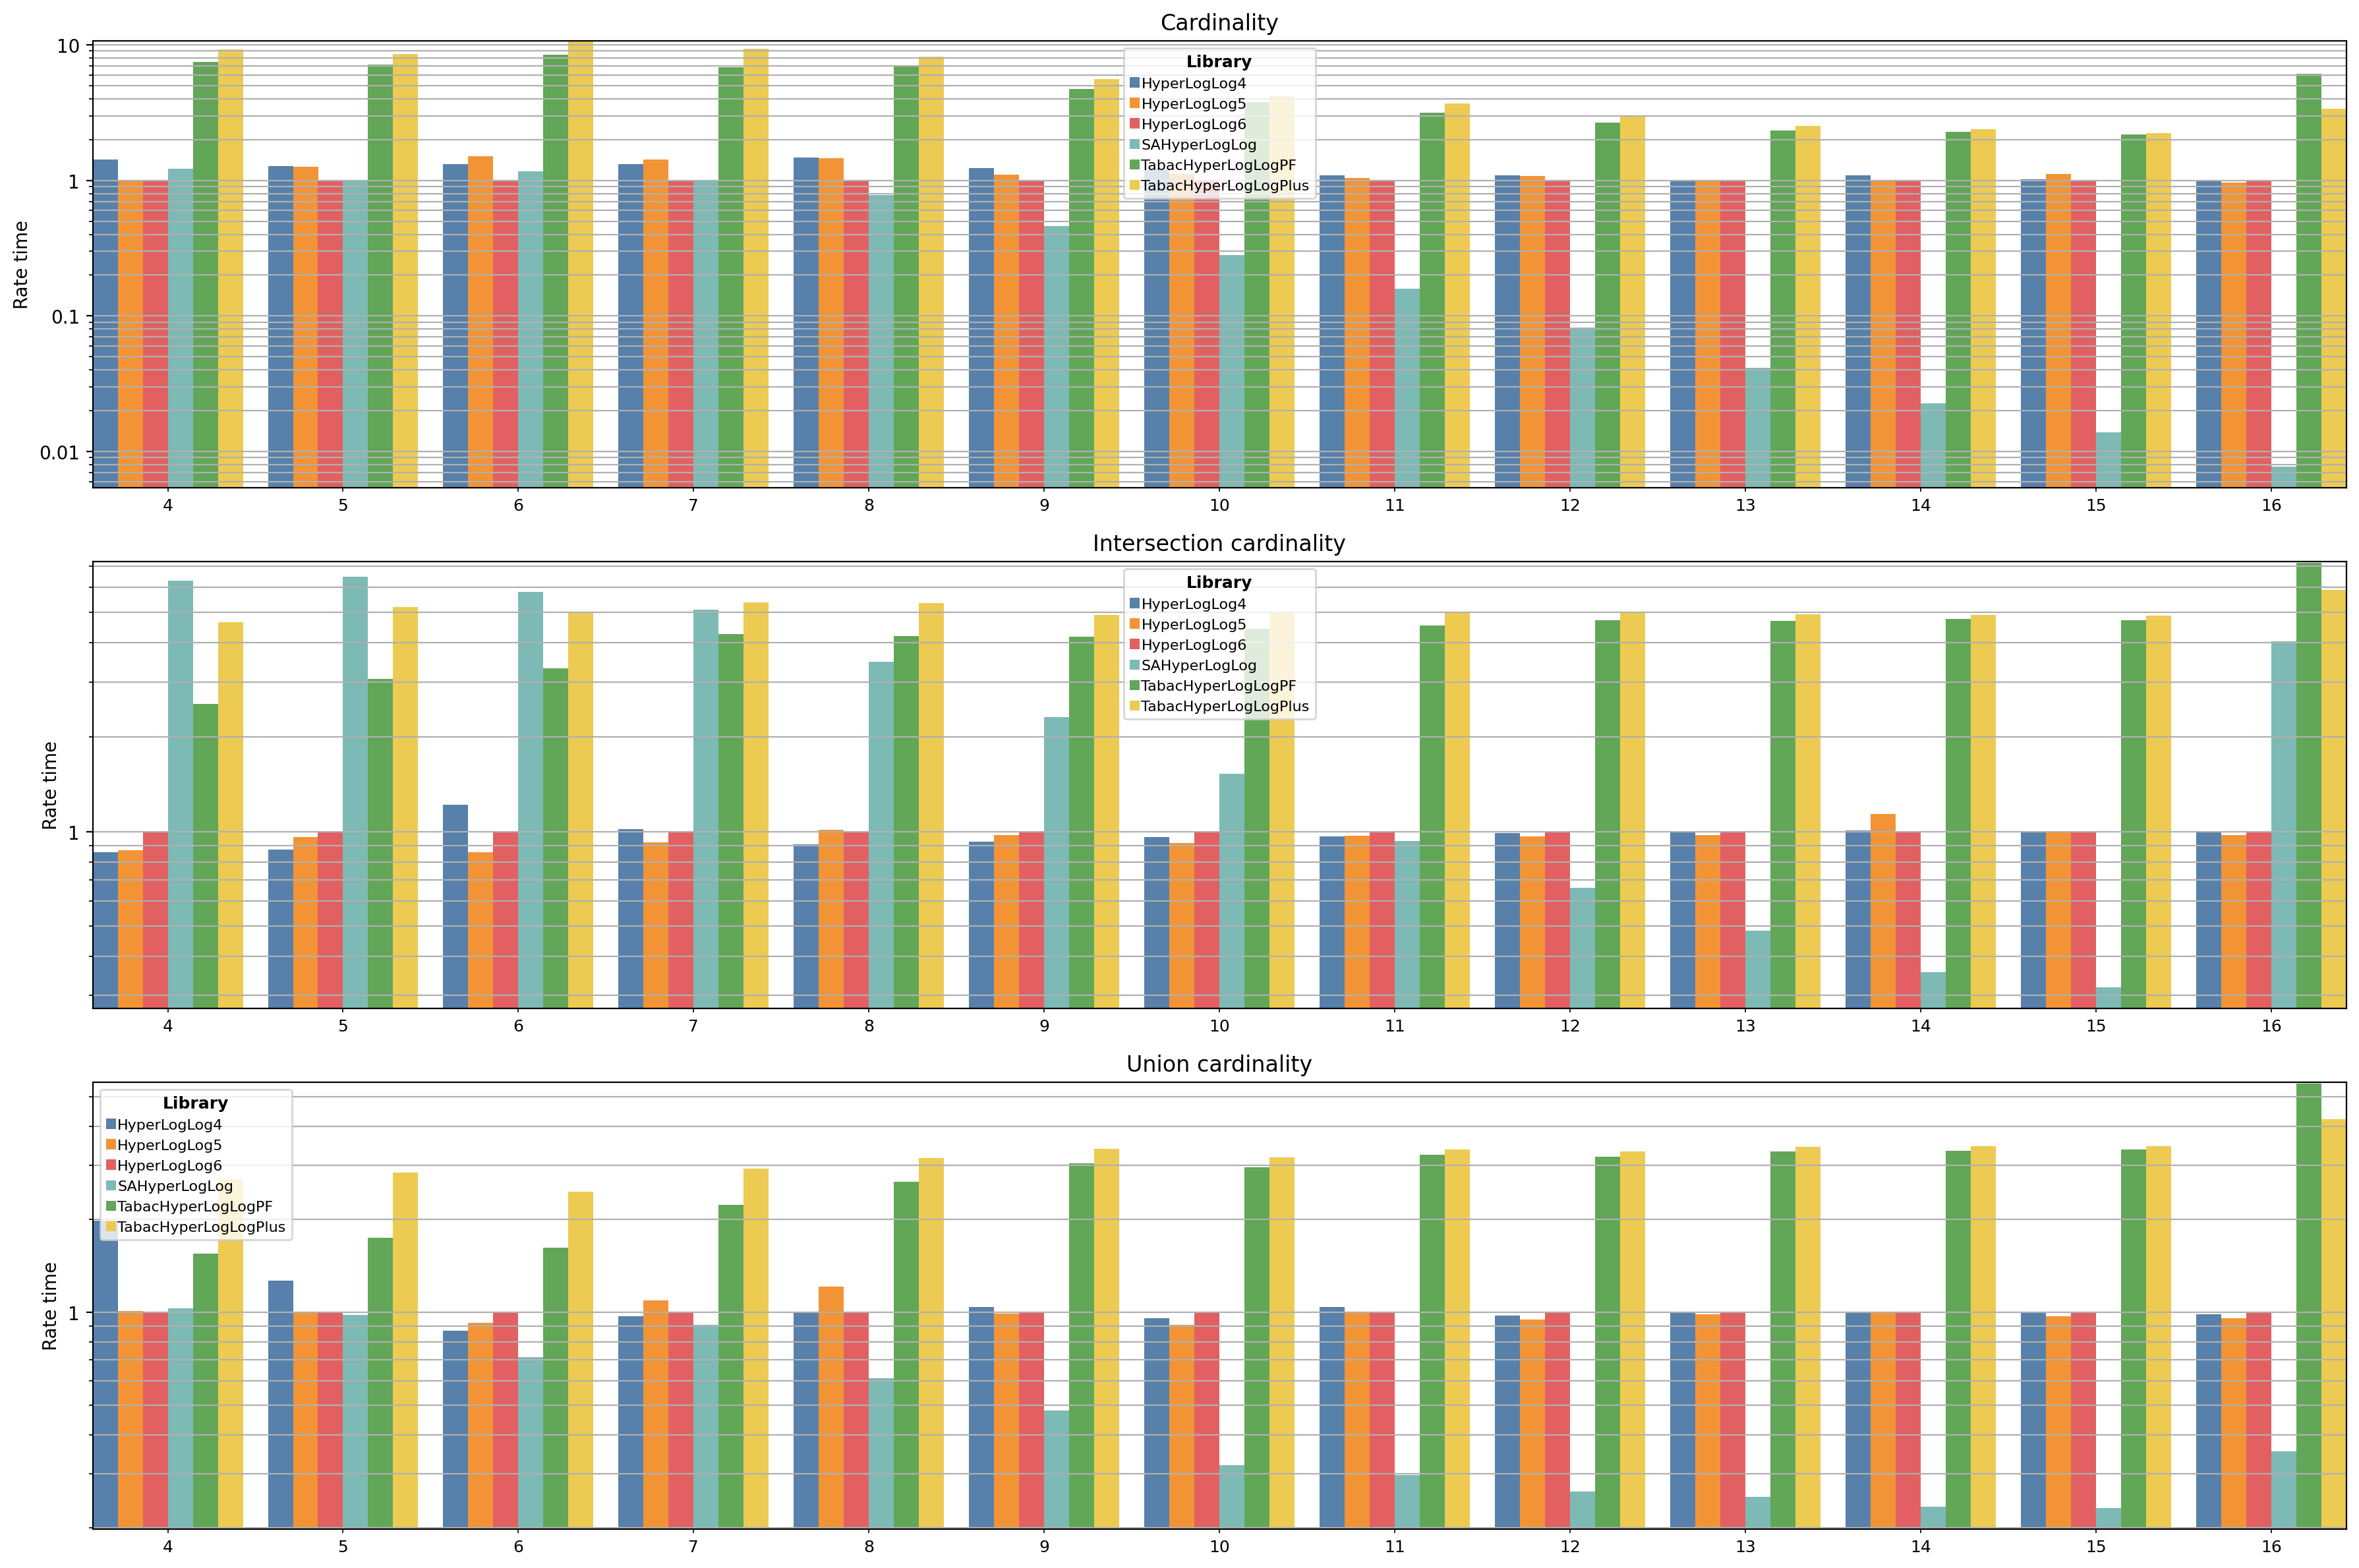

In [5]:
from barplots import barplots

def sort_by_precision(df2):
    df2["precision_float"] = df2.reset_index()[("precision",)].astype(float).astype(int).values
    df2["library_name"] = df2.reset_index()[("library",)].str.len()
    return df2.sort_values(["precision_float", "library_name"]).drop(columns=["precision_float", "library_name"])

for tag in tqdm(("squared_error", "time"), desc="Plotting", leave=False):
    rates[f"rate_{tag}"] = rates["rate"]
    _ = barplots(
        rates[rates["column"].str.contains(tag)][["task", "precision", "library", f"rate_{tag}"]],
        groupby=["task", "precision", "library"],
        subplots=True,
        bar_width=0.2,
        unique_minor_labels=False,
        unique_major_labels=False,
        sort_bars=sort_by_precision,
        minor_rotation=0,
        height=4,
        scale="log"
    )

In [ ]:
from tqdm.auto import tqdm
import numpy as np

tasks = [
    column.replace("_squared_error", "")
    for column in results.columns
    if "squared_error" in column
]

rates = []

for task in tqdm(tasks, desc="Computing rates", leave=False):
    for precision in tqdm(results.precision.unique(), desc=f"Precision", leave=False):
        if pd.isna(precision):
            continue
        reference = results[
            (results.precision == precision) &
            (results.library == "HyperLogLog")
        ]
        if reference.empty:
            raise ValueError(f"No reference for precision {precision}")
        for library in results.library.unique():
            if library == "HashSet":
                continue
            this_struct = results[
                (results.precision == precision) &
                (results.library == library)
            ]
            for column in ["memory_requirements", f"{task}_squared_error", f"{task}_time"]:
                rate = this_struct[column].mean() / reference[column].mean()
                assert np.isfinite(rate), (
                    f"Rate is not finite for task {task}, precision {precision}, "
                    f"library {library}, column {column}. The reference value is "
                    f"{reference[column].mean()}. The value is {this_struct[column].mean()}."
                )
                rates.append({
                    "task": task,
                    "precision": precision,
                    "library": library,
                    "column": column,
                    "rate": rate
                })

rates = pd.DataFrame(rates)
rates

In [5]:
squared_errors = [
    column
    for column in results.columns
    if "squared_error" in column
]

mean_results = results.drop(columns=["struct_name"]).groupby(["library", "precision"]).agg(["mean", "std"])

for column in squared_errors:
    time_column = column.replace("squared_error", "time")
    mean_results["loss"] = mean_results[(column, "mean")]#  * mean_results[("memory_requirements", "mean")] # * mean_results[(time_column, "mean")]
    mean_results = mean_results.sort_values(by="loss")
    display(mean_results[["loss", "memory_requirements", column, time_column]].head(10))

loss memory_requirements              \
                                                            mean         std   
library              precision                                                 
HyperLogLog          16         2.868940e+06         104872.0000    0.000000   
                     15         3.427533e+06          52440.0000    0.000000   
TabacHyperLogLogPlus 16         1.126224e+07         322266.1634  144.377125   
TabacHyperLogLogPF   16         1.166558e+07          87528.0000    0.000000   
HyperLogLog          14         1.246418e+07          26224.0000    0.000000   
TabacHyperLogLogPlus 15         2.244472e+07         161485.0236   83.577042   
TabacHyperLogLogPF   15         2.293094e+07          43840.0000    0.000000   
HyperLogLog          13         2.854380e+07          13120.0000    0.000000   
                     12         4.098205e+07           6568.0000    0.000000   
TabacHyperLogLogPlus 14         4.616949e+07          80871.9524   64.515607   

                               intersection_cardinality_squared_error  \
                                                                 mean   
library              precision                                          
HyperLogLog          16                                  2.868940e+06   
                     15                                  3.427533e+06   
TabacHyperLogLogPlus 16                                  1.126224e+07   
TabacHyperLogLogPF   16                                  1.166558e+07   
HyperLogLog          14                                  1.246418e+07   
TabacHyperLogLogPlus 15                                  2.244472e+07   
TabacHyperLogLogPF   15                                  2.293094e+07   
HyperLogLog          13                                  2.854380e+07   
                     12                                  4.098205e+07   
TabacHyperLogLogPlus 14                                  4.616949e+07   

                                             intersection_cardinality_time  \
                                         std                          mean   
library              precision                                               
HyperLogLog          16         5.119570e+06                   101648.3406   
                     15         5.509540e+06                    50758.3846   
TabacHyperLogLogPlus 16         1.779192e+07                   597757.0861   
TabacHyperLogLogPF   16         1.846750e+07                   731323.5683   
HyperLogLog          14         1.542403e+07                    25242.6121   
TabacHyperLogLogPlus 15         3.462983e+07                   247911.2059   
TabacHyperLogLogPF   15         3.708065e+07                   239474.4527   
HyperLogLog          13         2.514421e+07                    12882.2642   
                     12         5.749170e+07                     6555.2724   
TabacHyperLogLogPlus 14         7.360393e+07                   124021.0643   

                                               
                                          std  
library              precision                 
HyperLogLog          16          47926.749342  
                     15          27888.241855  
TabacHyperLogLogPlus 16         304613.645970  
TabacHyperLogLogPF   16         416234.842292  
HyperLogLog          14           6065.550804  
TabacHyperLogLogPlus 15          84227.947326  
TabacHyperLogLogPF   15          75212.209606  
HyperLogLog          13           3938.271263  
                     12           2206.572615  
TabacHyperLogLogPlus 14          34975.177576

loss memory_requirements              \
                                                            mean         std   
library              precision                                                 
HyperLogLog          16         5.598804e+05         104872.0000    0.000000   
                     15         1.522831e+06          52440.0000    0.000000   
SAHyperLogLog        15         1.614992e+06          65648.0000    0.000000   
                     12         2.630722e+06           8304.0000    0.000000   
                     16         5.194871e+06         131184.0000    0.000000   
HyperLogLog          11         5.399005e+06           3288.0000    0.000000   
                     14         1.157907e+07          26224.0000    0.000000   
TabacHyperLogLogPlus 16         1.513093e+07         322266.1634  144.377125   
TabacHyperLogLogPF   16         1.553986e+07          87528.0000    0.000000   
SAHyperLogLog        14         2.760360e+07          32880.0000    0.000000   

                               union_cardinality_squared_error                \
                                                          mean           std   
library              precision                                                 
HyperLogLog          16                           5.598804e+05  1.861415e+06   
                     15                           1.522831e+06  2.118821e+06   
SAHyperLogLog        15                           1.614992e+06  2.408162e+06   
                     12                           2.630722e+06  1.422893e+07   
                     16                           5.194871e+06  1.987526e+06   
HyperLogLog          11                           5.399005e+06  2.873789e+07   
                     14                           1.157907e+07  5.107168e+06   
TabacHyperLogLogPlus 16                           1.513093e+07  2.180164e+07   
TabacHyperLogLogPF   16                           1.553986e+07  2.231806e+07   
SAHyperLogLog        14                           2.760360e+07  6.676053e+06   

                               union_cardinality_time                 
                                                 mean            std  
library              precision                                        
HyperLogLog          16                   102557.4783  164021.730517  
                     15                    50405.3281   11790.669514  
SAHyperLogLog        15                    11692.1674    3464.883616  
                     12                     1738.9778    1296.952252  
                     16                    36277.2447  101656.258678  
HyperLogLog          11                     3314.1723    1442.053619  
                     14                    25275.2616    6480.456173  
TabacHyperLogLogPlus 16                   432517.6701  256176.805442  
TabacHyperLogLogPF   16                   566434.6507  303010.761871  
SAHyperLogLog        14                     5908.0180    1802.727262

loss memory_requirements              \
                                                            mean         std   
library              precision                                                 
HyperLogLog          16         1.696569e+06         104872.0000    0.000000   
                     15         2.439306e+06          52440.0000    0.000000   
SAHyperLogLog        15         2.676203e+06          65648.0000    0.000000   
                     16         5.745544e+06         131184.0000    0.000000   
HyperLogLog          14         1.202208e+07          26224.0000    0.000000   
SAHyperLogLog        12         1.303215e+07           8304.0000    0.000000   
TabacHyperLogLogPlus 16         1.309743e+07         322266.1634  144.377125   
TabacHyperLogLogPF   16         1.350070e+07          87528.0000    0.000000   
SAHyperLogLog        14         2.230099e+07          32880.0000    0.000000   
TabacHyperLogLogPlus 15         2.610547e+07         161485.0236   83.577042   

                               cardinality_squared_error                \
                                                    mean           std   
library              precision                                           
HyperLogLog          16                     1.696569e+06  2.481999e+06   
                     15                     2.439306e+06  2.793635e+06   
SAHyperLogLog        15                     2.676203e+06  3.386491e+06   
                     16                     5.745544e+06  3.189584e+06   
HyperLogLog          14                     1.202208e+07  8.347522e+06   
SAHyperLogLog        12                     1.303215e+07  2.096279e+07   
TabacHyperLogLogPlus 16                     1.309743e+07  1.845968e+07   
TabacHyperLogLogPF   16                     1.350070e+07  1.918253e+07   
SAHyperLogLog        14                     2.230099e+07  1.011741e+07   
TabacHyperLogLogPlus 15                     2.610547e+07  3.573420e+07   

                               cardinality_time                 
                                           mean            std  
library              precision                                  
HyperLogLog          16              68226.3329  145521.930199  
                     15              34008.2187    8825.937675  
SAHyperLogLog        15                470.0350    4161.788462  
                     16                529.4016     633.490735  
HyperLogLog          14              16863.0515   12160.949555  
SAHyperLogLog        12                360.7660     201.839014  
TabacHyperLogLogPlus 16             229731.5600  235606.864801  
TabacHyperLogLogPF   16             415968.9595  396781.635095  
SAHyperLogLog        14                380.4950     434.918227  
TabacHyperLogLogPlus 15              75646.7978   37514.527254

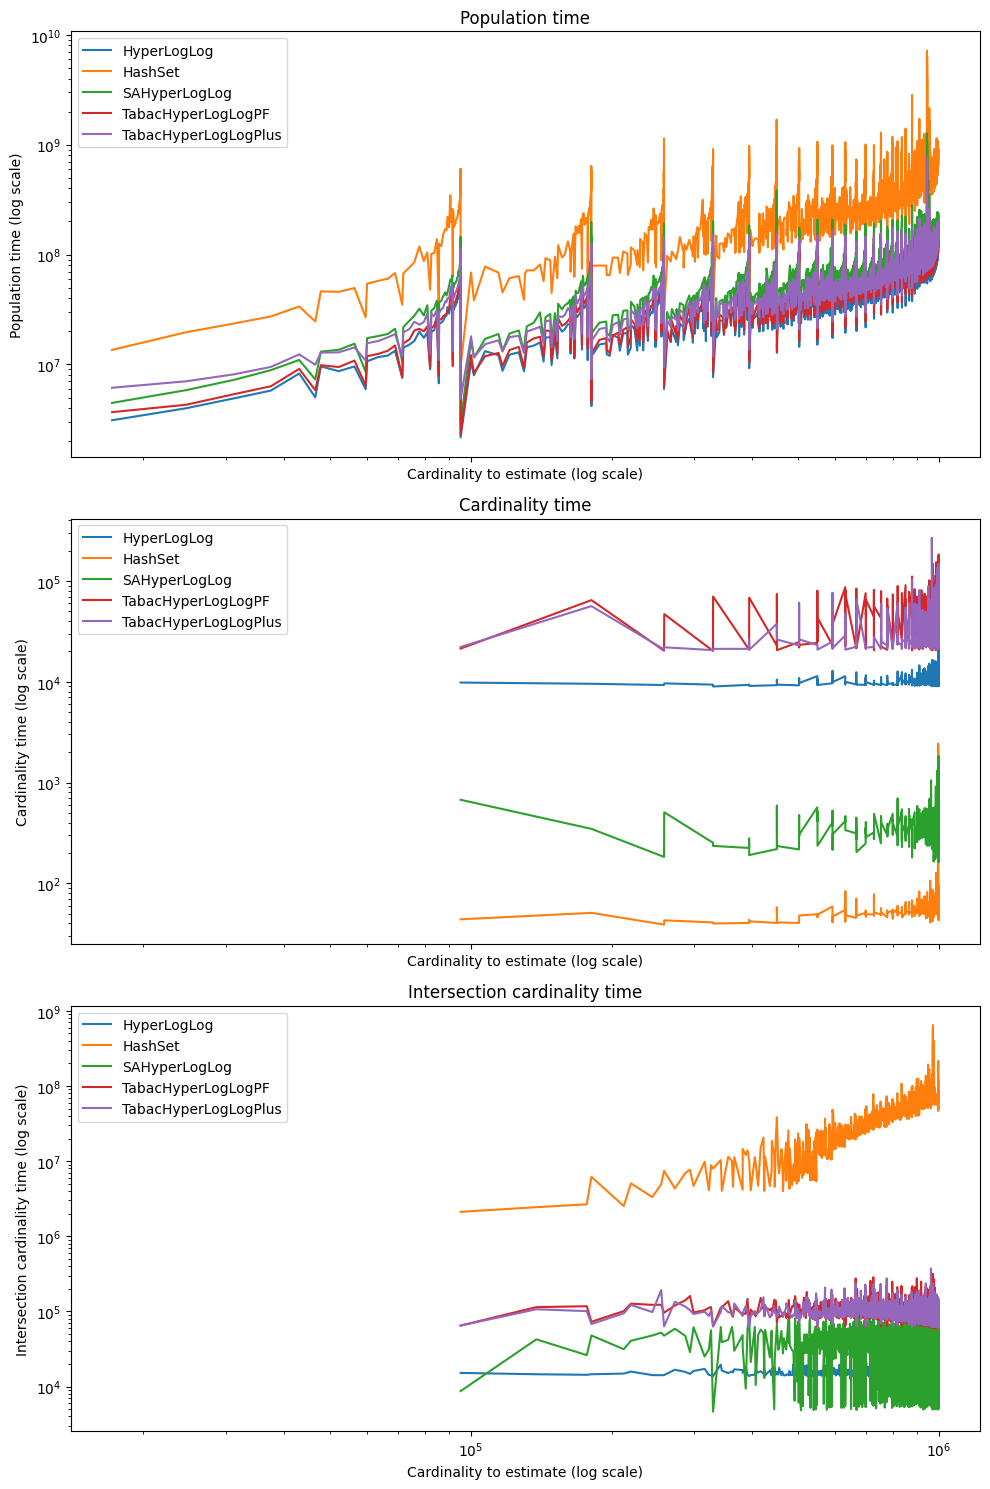

In [38]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

squared_errors = [
    column
    for column in results.columns
    if "squared_error" in column
]

times = [
    column
    for column in results.columns
    if "time" in column
]

exact_cardinalities = [
    column
    for column in results.columns
    if "exact" in column
]

# We plot the squared errors by memory requirements for each struct name.
# Each squared error is plot in a separate subplot.

fig, axes = plt.subplots(
    nrows=len(squared_errors),
    ncols=1,
    figsize=(10, 5 * len(squared_errors)), 
    sharex=True,
)

for ax, squared_error, time, exact_cardinality in zip(axes, squared_errors, times, exact_cardinalities):
    for library in results['library'].unique():
        filtered = results.loc[results['library'] == library].copy()
        filtered = filtered.drop(
            columns=[
                "library", "struct_name"
            ]
        )
        filtered = filtered.groupby(exact_cardinality).mean().reset_index()
        filtered = filtered.sort_values(by=exact_cardinality)
        
        ax.plot(
            filtered[exact_cardinality],
            filtered[time],
            label=library,
        )
    ax.legend()
    ax.set_title(sanitize_ml_labels(time))
    ax.set_ylabel(f"{sanitize_ml_labels(time)} (log scale)")
    ax.set_xlabel("Cardinality to estimate (log scale)")
    ax.set_xscale('log')
    ax.set_yscale('log')

fig.tight_layout()
#fig.savefig('results.png')
plt.show()

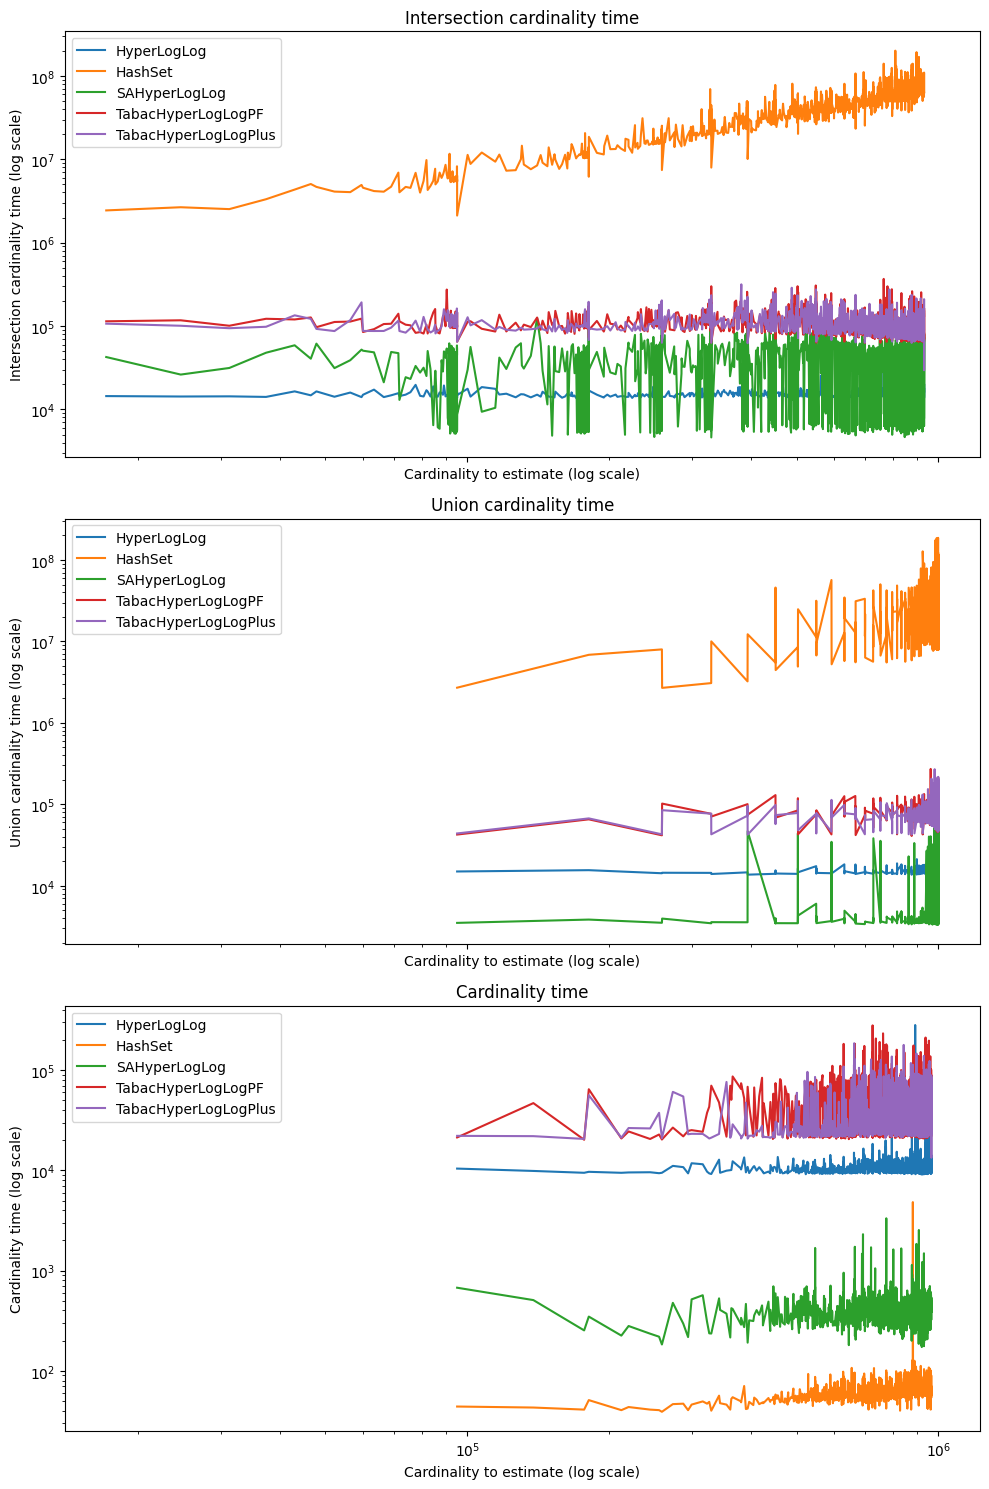

In [6]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

exact_cardinalities = [
    column
    for column in results.columns
    if "exact" in column
]

# We plot the squared errors by memory requirements for each struct name.
# Each squared error is plot in a separate subplot.

fig, axes = plt.subplots(
    nrows=len(exact_cardinalities),
    ncols=1,
    figsize=(10, 5 * len(exact_cardinalities)), 
    sharex=True,
)

for ax,exact_cardinality in zip(axes, exact_cardinalities):
    time_column = exact_cardinality.replace("exact_", "") + "_time"
    for library in results['library'].unique():

        filtered = results.loc[results['library'] == library].copy()
        filtered = filtered.drop(
            columns=[
                "library", "struct_name"
            ]
        )
        filtered = filtered.groupby(exact_cardinality).mean().reset_index()
        filtered = filtered.sort_values(by=exact_cardinality)
        
        ax.plot(
            filtered[exact_cardinality],
            filtered[time_column],
            label=library,
        )
    ax.legend()
    ax.set_title(sanitize_ml_labels(time_column))
    ax.set_ylabel(f"{sanitize_ml_labels(time_column)} (log scale)")
    ax.set_xlabel("Cardinality to estimate (log scale)")
    ax.set_xscale('log')
    ax.set_yscale('log')

fig.tight_layout()
#fig.savefig('results.png')
plt.show()

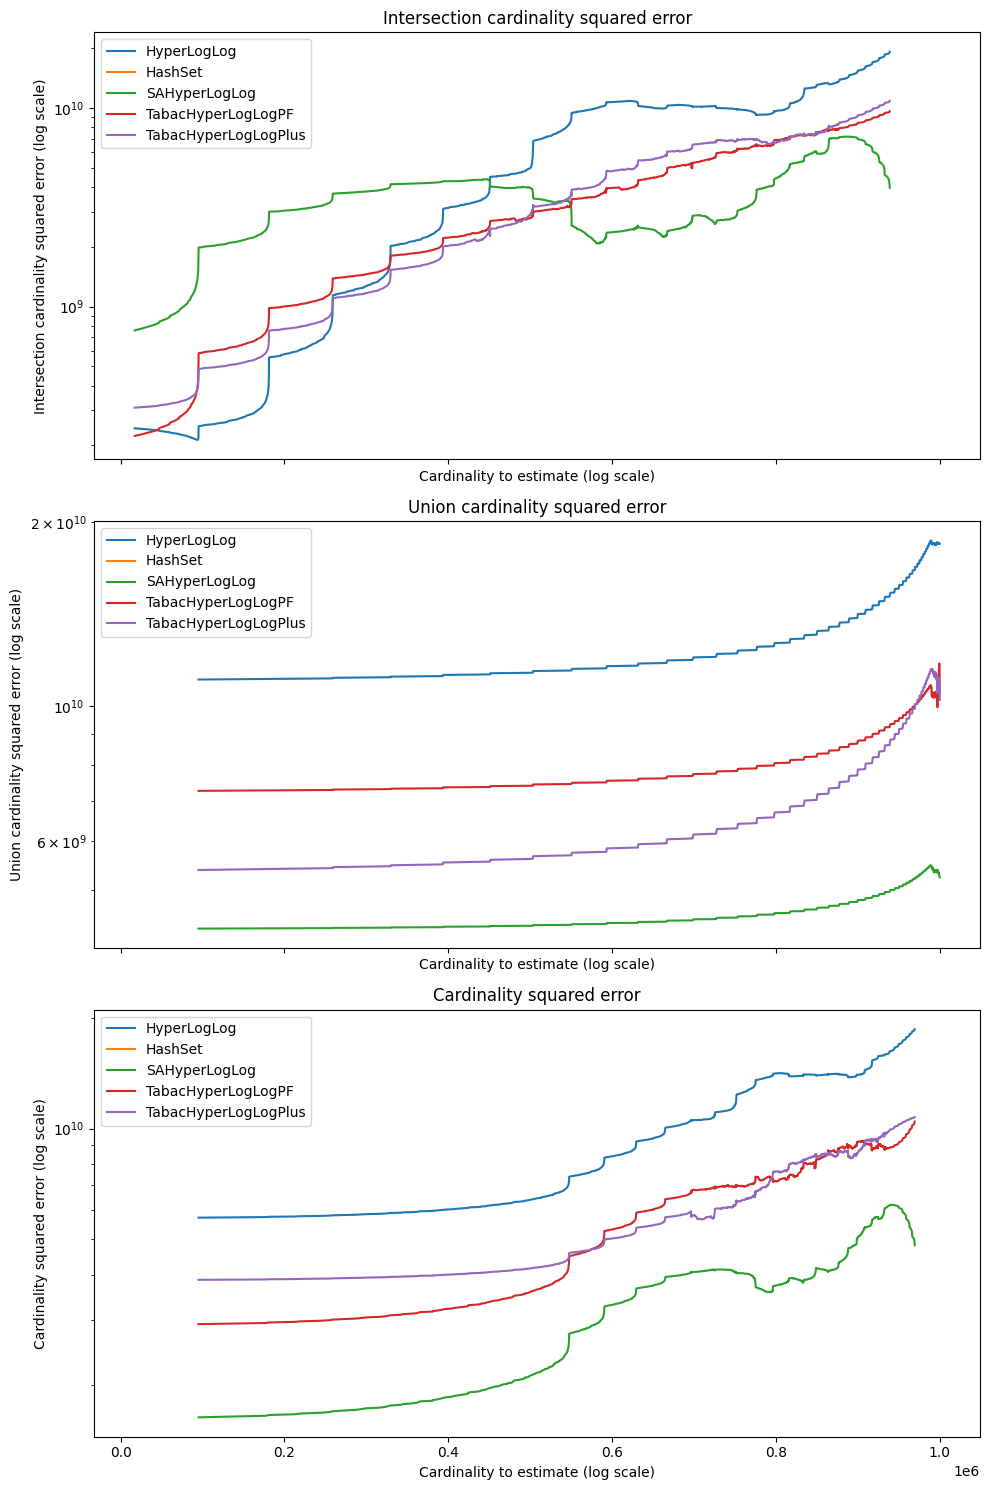

In [3]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels
from scipy.signal import savgol_filter


exact_cardinalities = [
    column
    for column in results.columns
    if "exact" in column
]

# We plot the squared errors by memory requirements for each struct name.
# Each squared error is plot in a separate subplot.

fig, axes = plt.subplots(
    nrows=len(exact_cardinalities),
    ncols=1,
    figsize=(10, 5 * len(exact_cardinalities)), 
    sharex=True,
)

for ax,exact_cardinality in zip(axes, exact_cardinalities):
    squared_error_column = exact_cardinality.replace("exact_", "") + "_squared_error"
    for library in results['library'].unique():

        filtered = results.loc[results['library'] == library].copy()
        filtered = filtered.drop(
            columns=[
                "library", "struct_name"
            ]
        )
        filtered = filtered.groupby(exact_cardinality).mean().reset_index()
        filtered = filtered.sort_values(by=exact_cardinality)
        
        ax.plot(
            filtered[exact_cardinality],
            savgol_filter(filtered[squared_error_column], 1013, 2),
            label=library,
        )
    ax.legend()
    ax.set_title(sanitize_ml_labels(squared_error_column))
    ax.set_ylabel(f"{sanitize_ml_labels(squared_error_column)} (log scale)")
    ax.set_xlabel("Cardinality to estimate (log scale)")
    #ax.set_xscale('log')
    ax.set_yscale('log')

fig.tight_layout()
#fig.savefig('results.png')
plt.show()

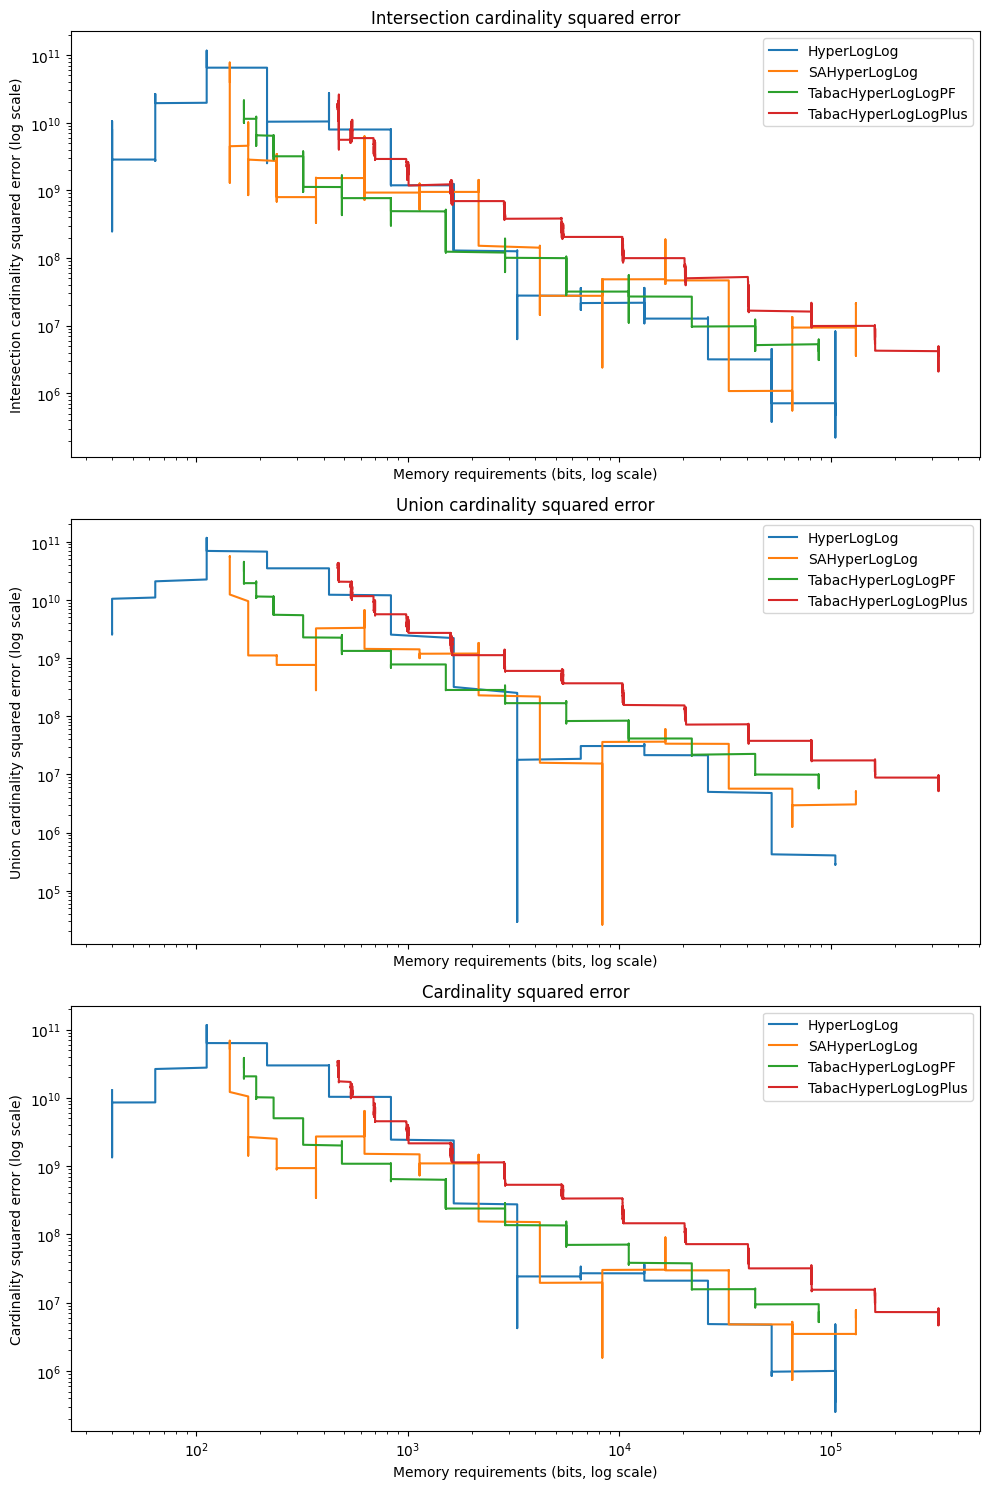

In [39]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels
import numpy as np
from scipy.signal import savgol_filter

def smoother(values, windows_size=173):
    values_copy = values.copy()
    for i in range(values_copy.size):
        values_copy[i] = np.median(
            values[max(0, i - windows_size):min(i + windows_size, values.size)]
        )
    return values_copy

error_columns = [
    column
    for column in results.columns
    if "error" in column
]

# We plot the squared errors by memory requirements for each struct name.
# Each squared error is plot in a separate subplot.

fig, axes = plt.subplots(
    nrows=len(exact_cardinalities),
    ncols=1,
    figsize=(10, 5 * len(exact_cardinalities)), 
    sharex=True,
)

for ax, error_column in zip(axes, error_columns):
    for library in results['library'].unique():

        if library == 'HashSet':
            continue

        filtered = results.loc[results['library'] == library].copy()
        filtered = filtered.drop(
            columns=[
                "library", "struct_name"
            ]
        )
        filtered = filtered.sort_values(by="memory_requirements")

        ax.plot(
            filtered["memory_requirements"],
            smoother(filtered[error_column].values),
            label=library,
        )
    ax.legend()
    ax.set_title(sanitize_ml_labels(error_column))
    ax.set_ylabel(f"{sanitize_ml_labels(error_column)} (log scale)")
    ax.set_xlabel("Memory requirements (bits, log scale)")
    ax.set_xscale('log')
    ax.set_yscale('log')

fig.tight_layout()
#fig.savefig('results.png')
plt.show()